In [ ]:
#| default_exp effects_explorer

# effects_explorer

> See how effects get mapped by pretrained autoencod

In [ ]:
is_notebook = True  # runs in notebook and exported .py

In [ ]:
# this cell is for Colab execution
install = False  # can set to false to skip this part, e.g. for re-running in same session
if install:     # ffmpeg is to add MP3 support to Colab
    !yes | sudo apt install ffmpeg 
    !pip install -Uqq einops gdown 
    !pip install -Uqq git+https://github.com/drscotthawley/aeiou@dev   # or however you get dev branch
    !pip install -Uqq git+https://github.com/drscotthawley/audio-algebra # note that we're in a-a now

In [ ]:
# this cell is because on the cluster schedule affinity defaults to 2 for some dumb reason
import os
import sys
import multiprocessing
#multiprocessing.set_start_method('fork') # turns out this will f things up bad. no. 

def fix_affinity():
    # 0 means current process
    affinity = os.sched_getaffinity(0)
    if len(affinity) != multiprocessing.cpu_count():
        print("Something has messed with CPU affinity. Current affinity is {}. Fixing".format(affinity),
              file=sys.stderr)
        os.sched_setaffinity(0, set(range(multiprocessing.cpu_count())))

        assert len(os.sched_getaffinity(0)) == multiprocessing.cpu_count(), os.sched_getaffinity(0)
    else:
        print("Affinity is OK: {}".format(affinity))

#fix_affinity()
#os.environ['NUMBA_NUM_THREADS'] = str(len(os.sched_getaffinity(0)))

In [ ]:
#| export
import os
import numpy as np
import pandas as pd
import math
import plotly.express as px
import torch
from torch.utils import data as torchdata
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Audio  # just for displaying inside notebooks
import inspect
from einops import rearrange
from tqdm import tqdm

import umap
import umap.plot
import umap.utils as utils
import umap.aligned_umap

import wandb

# other audio packages
import pyloudnorm as pyln
use_pedalboard = True
if use_pedalboard:
    from pedalboard import Pedalboard, Distortion, Reverb, Compressor, HighpassFilter, LowpassFilter, Chorus, Compressor, Delay, Gain, Phaser
else: 
    from audiomentations import *   # list of effects

# my audio packages
from aeiou.viz import playable_spectrogram, audio_spectrogram_image, tokens_spectrogram_image, point_cloud, show_point_cloud, project_down
from aeiou.core import load_audio, get_device
from aeiou.datasets import Stereo, Mono

from audio_algebra.given_models import GivenModelClass, SpectrogramAE, MagSpectrogramAE, \
    MagDPhaseSpectrogramAE, MelSpectrogramAE, DVAEWrapper, RAVEWrapper, StackedDiffAEWrapper
from aeiou.datasets import AudioDataset
from audio_algebra.datasets import DualEffectsDataset
from audio_algebra.aa_mixer import * 

#fix_affinity()

In [ ]:
device = get_device()
print(f"device = {device}, CPUs = {os.cpu_count()}, len(sched_affinity) = {len(os.sched_getaffinity(0))}")

device = cuda, CPUs = 64, len(sched_affinity) = 64


# Set Up Data Loading

In [ ]:
dataset_name = 'guitarset'
#dataset_name = 'guitar-and-piano'
#dataset_name = 'IDMT_SMT_AUDIO_EFFECTS/Gitarre monophon/Samples/NoFX'
training_dir =  f'{os.getenv("HOME")}/datasets/{dataset_name}/'
print(f"training_dir = {training_dir}")
assert os.path.exists(training_dir)

#these params are good for SageMaker Studio, ml.g5.2xlarge instance
batch_size = 180
load_frac = 1.0
seed = 1 
num_workers = 12
sample_rate = 48000  # tbh don't know what happens if you change this val
norm_before_fx = True # apply per-waveform normalization before passing into fx
norm_after_fx = True  # and after applying fx

training_dir = /home/shawley/datasets/guitarset/


In [ ]:
#normalizations

meter = pyln.Meter(sample_rate, block_size=0.200)     # loudness meter

def do_loudnorm(waveform, db_norm=-24.0, debug=False):
    loudness = meter.integrated_loudness(waveform.T)
    if math.isinf(loudness):
        print(f"Hold up. loudness = {loudness}")
        nb_play(waveform)
        assert False
    return pyln.normalize.loudness(waveform.T, loudness, db_norm).T

def do_maxabsnorm(waveform, newmax=0.5,  debug=False):
    current_peak = np.max(np.abs(waveform))
    return newmax*waveform/(current_peak)


In [ ]:
print("Setting up dataset")
torch.manual_seed(seed)
dataset = AudioDataset(training_dir, load_frac=load_frac, return_dict=True)
dl = torchdata.DataLoader(dataset, batch_size, shuffle=False,   # note shuffling is on
                num_workers=num_workers, persistent_workers=True, pin_memory=True)
assert len(dataset) > 0 

Setting up dataset
augs = Stereo(), PhaseFlipper()
AudioDataset:360 files found.


## Actually, let's read all input data into RAM
First, read entire (small?) dataset into RAM, for consistency later

In [ ]:
ins_data_orig = None
filenames = []
for bi, batch in enumerate(tqdm(dl)):
    data = batch['inputs']
    if norm_before_fx: data = np.apply_along_axis(do_maxabsnorm, -1, data)
    filenames += batch['filename']
    ins_data_orig = data if ins_data_orig is None else np.concatenate((ins_data_orig, data), axis=0) 
print(ins_data_orig.shape)
assert ins_data_orig.shape[0] == len(dataset)

100%|██████████| 2/2 [00:05<00:00,  2.62s/it]

(360, 2, 65536)


### And let's listen to a bit of audio:

In [ ]:
dataset.__getitem__(0)

{'filename': '/home/shawley/datasets/guitarset/solo/04_BN3-119-G_solo_mic.wav',
 'inputs': tensor([[ 0.0103,  0.0084,  0.0062,  ..., -0.2159, -0.2164, -0.2177],
         [ 0.0103,  0.0084,  0.0062,  ..., -0.2159, -0.2164, -0.2177]]),
 'crop_range': tensor([25610, 91146])}

waveform.shape = (2, 65536)


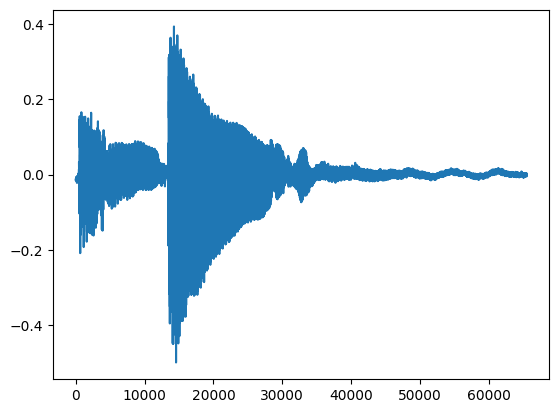

/fsx/shawley/envs_sm/aa/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(
/fsx/shawley/envs_sm/aa/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


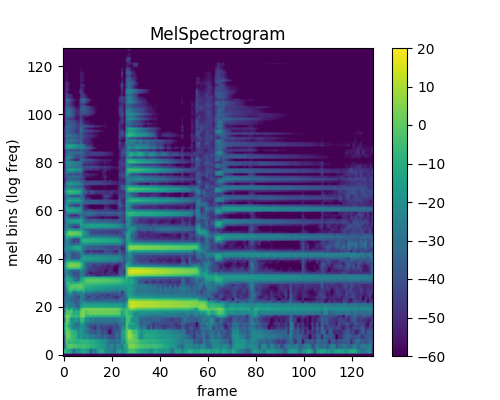

In [ ]:
#waveform = dataset.__getitem__(0)['inputs'].numpy()
waveform = ins_data_orig[0]
print("waveform.shape =",waveform.shape)

def nb_play(waveform):
    if is_notebook: 
        if waveform is torch.Tensor: waveform = waveform.cpu().numpy()
        display(Audio(waveform.clip(-1,1), rate=sample_rate, normalize=False))
        plt.plot(waveform[0]) # just left channel for now
        plt.show()
        display(audio_spectrogram_image(torch.from_numpy(waveform), justimage=False, db=False, db_range=[-60,20]))
        
nb_play(waveform)

### List of effects

In [ ]:
class Clean:
    "no-op audio effect, in the style of audiomentations"
    def __init__(self, p=1.0, no_op=0): 
        self.name = 'Clean'
    def __call__(self,x, sample_rate=48000): return x 

if use_pedalboard:
    #effects_list = [Clean, Distortion, LowpassFilter#, Reverb, Compressor, HighpassFilter]
    effects_list = [Distortion, Reverb, HighpassFilter, LowpassFilter]
    #effects_list = [HighpassFilter]

else:   # audiomentations
    effects_list = [Clean, HighPassFilter, LowPassFilter]  # from audiomentations
    effects_list = [x(p=1.0) for x in effects_list]  # make probability of transform = 1

effect_names = [x.__class__.__name__ for x in [y() for y in effects_list]]

# one knob per effect
knob_names = {
    'Clean': {'knob_name': 'no_op', 'min': 0, 'max': 1, 'default':0},
    'Distortion': {'knob_name': 'drive_db', 'min': 0, 'max': 50, 'default':25},
    'Reverb': {'knob_name': 'room_size', 'min': 0.25, 'max': 0.99, 'default':0.8},
    'Compressor': {'knob_name': 'threshold_db', 'min': -12, 'max': -3, 'default':-6},
    'HighpassFilter': {'knob_name': 'cutoff_frequency_hz', 'min': 500, 'max': 5000, 'default':2000},
    'LowpassFilter': {'knob_name': 'cutoff_frequency_hz', 'min': 40, 'max': 500, 'default':70},
}
knob_names = {
    'Distortion': {'knob_name': 'drive_db', 'min': 0, 'max': 30, 'default':25},
    'Reverb': {'knob_name': 'room_size', 'min': 0, 'max': 0.99, 'default':0.8},
    'HighpassFilter': {'knob_name': 'cutoff_frequency_hz', 'min': 50, 'max': 10000, 'default':2000},
    'LowpassFilter': {'knob_name': 'cutoff_frequency_hz', 'min': 50, 'max': 10000, 'default':70},
}
for name in effect_names:
    print(f"{name}: {knob_names[name]}")

Distortion: {'knob_name': 'drive_db', 'min': 0, 'max': 30, 'default': 25}
Reverb: {'knob_name': 'room_size', 'min': 0, 'max': 0.99, 'default': 0.8}
HighpassFilter: {'knob_name': 'cutoff_frequency_hz', 'min': 50, 'max': 10000, 'default': 2000}
LowpassFilter: {'knob_name': 'cutoff_frequency_hz', 'min': 50, 'max': 10000, 'default': 70}


Distortion {'knob_name': 'drive_db', 'min': 0, 'max': 30, 'default': 25} drive_db 25


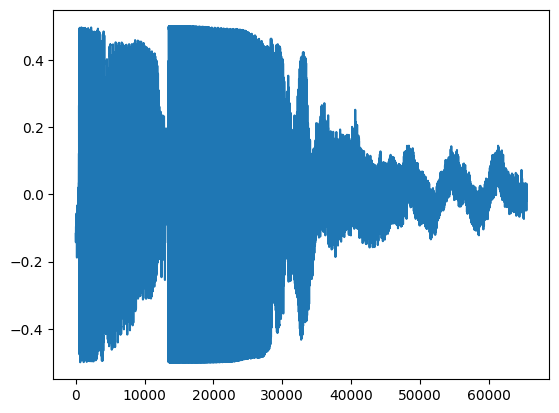

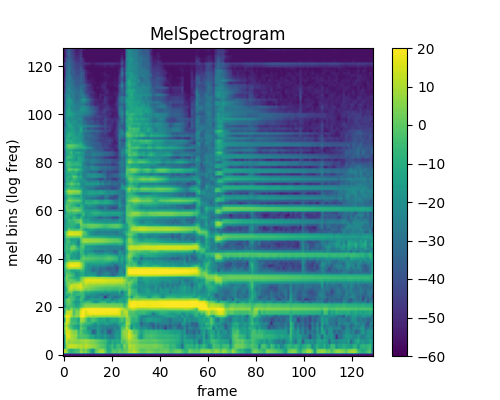

In [ ]:
# try an effect
e = effects_list[0]
name = effect_names[0]
kinfo = knob_names[name]
kname = kinfo['knob_name']
kval = kinfo['default']
print(name, kinfo, kname, kval)
board = Pedalboard([e(**{kname:kval})])

effected = board(waveform, sample_rate)
nb_play(do_maxabsnorm(effected))

# Interlude: parallel apply_along_axis

In [ ]:
# source: https://stackoverflow.com/questions/45526700/easy-parallelization-of-numpy-apply-along-axis


from multiprocessing.pool import ThreadPool as Pool


import numpy as np

def parallel_apply_along_axis(func1d, axis, arr, *args, **kwargs):
    """
    Like numpy.apply_along_axis(), but takes advantage of multiple
    cores.
    """        
    # Effective axis where apply_along_axis() will be applied by each
    # worker (any non-zero axis number would work, so as to allow the use
    # of `np.array_split()`, which is only done on axis 0):
    effective_axis = 1 if axis == 0 else axis
    if effective_axis != axis:
        arr = arr.swapaxes(axis, effective_axis)

    # Chunks for the mapping (only a few chunks):
    chunks = [(func1d, effective_axis, sub_arr, args, kwargs)
              for sub_arr in np.array_split(arr, multiprocessing.cpu_count())]
    #print("multiprocessing.cpu_count = ",multiprocessing.cpu_count())
    #print("chunks = ",chunks)

    pool = Pool() # multiprocessing.Pool()
    individual_results = pool.map(unpacking_apply_along_axis, chunks)
    # Freeing the workers:
    pool.close()
    pool.join()

    return np.concatenate(individual_results)

def unpacking_apply_along_axis(all_args):
    """…"""
    (func1d, axis, arr, args, kwargs) = all_args
    return np.apply_along_axis(func1d, axis, arr, *args, **kwargs)



# Apply Effects

In [ ]:
kturns = 32 #Knob turns.

In [ ]:
from numba import jit, njit, prange
import numpy.typing as npt
from typing import Callable


def apply_effect_normal(effect:Callable, audio_batch: npt.ArrayLike, sample_rate=48000) -> np.ndarray:
    return np.apply_along_axis(effect, -1, audio_batch, sample_rate)


@jit(parallel=True)
def apply_effect_numba(audio_batch: npt.ArrayLike, sample_rate=48000) -> np.ndarray:
    board = Pedalboard([Distortion(drive_db=25)])
    out = np.empty(audio_batch.shape)
    for i in prange(audio_batch.shape[0]):
        out[i] = board(audio_batch[i], sample_rate)
    return out

def apply_effect_list(effect:Callable, audio_batch: npt.ArrayLike, sample_rate=48000) -> np.ndarray:
    out_list = [effect(x, sample_rate) for x in audio_batch]
    return np.array(out_list) 


def apply_effect_parallel(effect:Callable, audio_batch: npt.ArrayLike, sample_rate=48000) -> np.ndarray:
    return parallel_apply_along_axis(effect, -1, audio_batch, sample_rate)


def apply_effect_normal(effect:Callable, audio_batch: npt.ArrayLike, sample_rate=48000) -> np.ndarray:
    return np.apply_along_axis(effect, -1, audio_batch, sample_rate)


def apply_effect_onebiglong(effect:Callable, audio_batch: npt.ArrayLike, sample_rate=48000) -> np.ndarray:
    " nope, no faster"
    longer = np.reshape(audio_batch, (2,-1))
    print("longer.shape = ",longer.shape)
    return np.apply_along_axis(effect, -1, audio_batch, sample_rate)

def apply_effect_3d(effect:Callable, audio_batch: npt.ArrayLike, sample_rate=48000) -> np.ndarray:
    return effect(audio_batch, sample_rate)


def apply_effect(effect:Callable, audio_batch: npt.ArrayLike, sample_rate=48000) -> np.ndarray:
    return apply_effect_normal(effect, audio_batch, sample_rate)


In [ ]:
# todo: build man df here and never again
audio_full = None # this will be the full set of audio sounds for the dataset

# build df as we go
columns = ['sample','filename','effect','knob_name','kval'] 
main_df = pd.DataFrame(columns=columns)
for ei, (name, effect) in enumerate(zip(effect_names, effects_list)):
    kinfo = knob_names[name]  # knob info
    kname, kdefault, kmin, kmax = kinfo['knob_name'], kinfo['default'], kinfo['min'], kinfo['max']
    kvals = np.logspace(np.log10(kmin), np.log10(kmax), kturns) if 'Filter' in name else np.linspace(kmin, kmax, kturns)
    for ki, kval in enumerate(pbar:=tqdm(kvals)):
        if kturns==1: kval = kdefault
        status = f"{ei+1}/{len(effects_list)}: {name}, knob: {kname}, setting {ki+1}/{kturns}: {kval:5.1f}"
        tqdm.write(status)
        board = effect() if ((name == 'Clean') or (not use_pedalboard)) else Pedalboard([effect(**{kname:kval})])
        #for bi, batch in enumerate(dl):   # dataloader iteration

        # Since we're on CPU for applying effects, our "batch size" is only limited by RAM
        batch = ins_data_orig #  [bi*batch_size: min(ins_data_orig.shape[0], (bi+1)*batch_size)] # grab a batch
            #already doing this above #if norm_before_fx: batch = np.apply_along_axis(do_maxabsnorm, -1, batch)
                
        if use_pedalboard:
            #fx_batch = np.apply_along_axis(board, -1, batch, sample_rate)
            fx_batch = apply_effect(board, batch, sample_rate=sample_rate)
            #fx_batch = apply_effect_numba(batch, sample_rate=sample_rate)
        else:
            fx_batch = np.array([effect(x, sample_rate=sample_rate) for x in batch]) # audiomentations

        if norm_after_fx: fx_batch = np.apply_along_axis(do_maxabsnorm, -1, fx_batch)

        # save for later
        audio_full = fx_batch if audio_full is None else np.concatenate((audio_full, fx_batch), axis=0) # don't hog vram

        batch_df = pd.DataFrame(columns=columns)
        batch_df['effect'] = [name]*len(dataset)
        batch_df['filename'] = [os.path.basename(x) for x in filenames]
        batch_df['knob_name'] = [kname]*len(dataset)
        batch_df['kval']  = [kval]*len(dataset)
        batch_df['sample'] = list(range(len(dataset)))
        main_df = pd.concat([main_df, batch_df], ignore_index=True)
        
    if name=='Clean': continue # don't do multiple knob values for Clean
        
print(f"\n audio_full.shape = {audio_full.shape}")


--- effect 0: Distortion,  knob drive_db, setting = 0/32:   0.0
--- effect 0: Distortion,  knob drive_db, setting = 1/32:   1.0
--- effect 0: Distortion,  knob drive_db, setting = 2/32:   1.9
--- effect 0: Distortion,  knob drive_db, setting = 3/32:   2.9
--- effect 0: Distortion,  knob drive_db, setting = 4/32:   3.9
--- effect 0: Distortion,  knob drive_db, setting = 5/32:   4.8
--- effect 0: Distortion,  knob drive_db, setting = 6/32:   5.8
--- effect 0: Distortion,  knob drive_db, setting = 7/32:   6.8
--- effect 0: Distortion,  knob drive_db, setting = 8/32:   7.7
--- effect 0: Distortion,  knob drive_db, setting = 9/32:   8.7
--- effect 0: Distortion,  knob drive_db, setting = 10/32:   9.7
--- effect 0: Distortion,  knob drive_db, setting = 11/32:  10.6
--- effect 0: Distortion,  knob drive_db, setting = 12/32:  11.6
--- effect 0: Distortion,  knob drive_db, setting = 13/32:  12.6
--- effect 0: Distortion,  knob drive_db, setting = 14/32:  13.5
--- effect 0: Distortion,  knob dri

In [ ]:
main_df

,sample,filename,effect,knob_name,kval
0,0,04_BN3-119-G_solo_mic.wav,Distortion,drive_db,0.0
1,1,00_SS3-84-Bb_solo_mic.wav,Distortion,drive_db,0.0
2,2,00_Rock1-90-C#_solo_mic.wav,Distortion,drive_db,0.0
3,3,01_Funk1-97-C_solo_mic.wav,Distortion,drive_db,0.0
4,4,01_Jazz2-110-Bb_solo_mic.wav,Distortion,drive_db,0.0
...,...,...,...,...,...
46075,355,03_Funk3-98-A_comp_mic.wav,LowpassFilter,cutoff_frequency_hz,10000.0
46076,356,03_BN1-147-Gb_comp_mic.wav,LowpassFilter,cutoff_frequency_hz,10000.0
46077,357,03_SS3-84-Bb_comp_mic.wav,LowpassFilter,cutoff_frequency_hz,10000.0
46078,358,05_Rock2-85-F_comp_mic.wav,LowpassFilter,cutoff_frequency_hz,10000.0


In [ ]:
path = '/fsx/shawley/datasets/stacked_'
np.save(path+'audio_full_4effects32knobs',audio_full)

In [ ]:
main_df.to_pickle(path+"main_df.pkl")

### Read saved audio

In [ ]:
path = '/fsx/shawley/datasets/stacked_'
audio_full = np.load(path+'audio_full_4effects32knobs.npy')

In [ ]:
main_df = pd.read_pickle(path+"main_df.pkl")

## Set up the Given [Auto]Encoder Model(s)

 Note that initially we're *only* going to be using the encoder part.
 The decoder -- with all of its sampling code, etc. -- will be useful eventualy, and we' go ahead and define it.  But fyi it won't be used *at all* while training the AA mixer model.  

In [ ]:
given_model = StackedDiffAEWrapper() # DVAEWrapper()
given_model.setup() 
given_model.to(device)
print("Given Autoencoder is ready to go!")

StackedDiffAEWrapper: attempting to load checkpoint ~/checkpoints/stacked-diffae-more-310k.ckpt
Checkpoint found!


Lightning automatically upgraded your loaded checkpoint from v1.7.4 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ~/checkpoints/stacked-diffae-more-310k.ckpt`


StackedDiffAEWrapper: Setup completed.
Given Autoencoder is ready to go!


# Encode effected Audio

In [ ]:
# just encoding
#@torch.jit.script
def encode_all(audio_full:torch.Tensor, batch_size:int, given_model:torch.nn.Module, device) -> torch.Tensor:
    nbatches = math.ceil(len(audio_full)/batch_size)
    reps_full = None
    for i in tqdm(range(nbatches)): 
        # grab a batch of audio
        start, end = i*batch_size, min(audio_full.shape[0], (i+1)*batch_size)
        fx_batch = audio_full[start:end].to(device)
        with torch.no_grad():
            reps = given_model.encode(fx_batch)

        if reps_full is None:
            reps_full = torch.empty((audio_full.shape[0], reps.shape[-2], reps.shape[-1])).cpu()
        reps_full[start:end] = reps.cpu()   # save VRAM  
    return reps_full

if audio_full is np.ndarray: audio_full = torch.from_numpy(audio_full)
reps_full = encode_all(audio_full, batch_size, given_model, device)
print(f"\n reps_full.shape = {reps_full.shape}")

In [ ]:
# just encoding
audio_full_tensor = torch.tensor(audio_full, requires_grad=False).cpu()
nbatches = math.ceil(len(audio_full)/batch_size)
reps_full = None
for i in tqdm(range(nbatches)): 
    # grab a batch of audio
    start, end = i*batch_size, min(audio_full.shape[0], (i+1)*batch_size)
    #fx_batch = torch.from_numpy(audio_full[start:end]).to(device)
    fx_batch = audio_full_tensor[start:end].to(device)
    with torch.no_grad():
        reps = given_model.encode(fx_batch).cpu()

    if reps_full is None:
        reps_full = torch.empty((audio_full.shape[0], reps.shape[-2], reps.shape[-1])).cpu()
    reps_full[start:end] = reps.cpu()   # save VRAM 
    #reps_full = reps if None == reps_full else torch.cat((reps_full, reps), dim=0)

        
print(f"\n reps_full.shape = {reps_full.shape}")

  6%|▋         | 16/256 [02:48<42:17, 10.57s/it]

In [ ]:
np.save(path+'reps_full_4effects32knobs',reps_full)

### Reload prior work

In [ ]:
reps_full = torch.from_numpy(np.load(path+'reps_full_4effects32knobs.npy'))
reps_full.shape

torch.Size([114176, 32, 128])

In [ ]:
# check for nans
assert 0 == len(torch.nonzero(torch.isnan(reps_full.view(-1)))), "You've got NaNs"
print("No NaNs! Good to go. ")

No NaNs! Good to go. 


### Listen to a few examples

name =  Distortion , ind = 11160


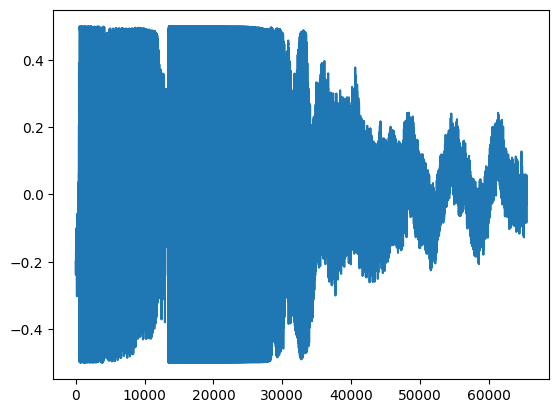

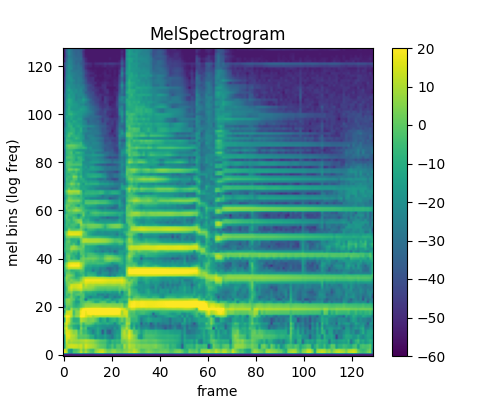

name =  Reverb , ind = 11520


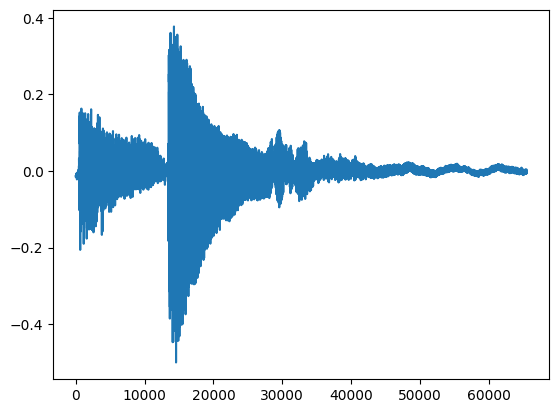

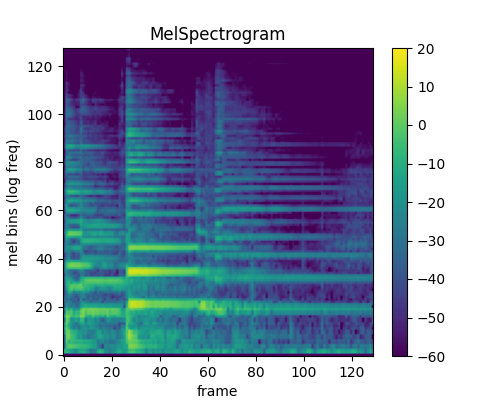

name =  HighpassFilter , ind = 11880


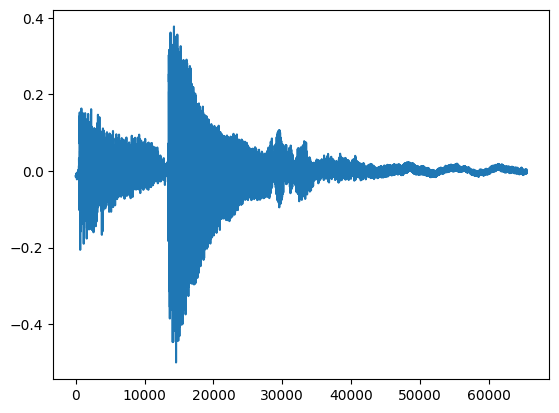

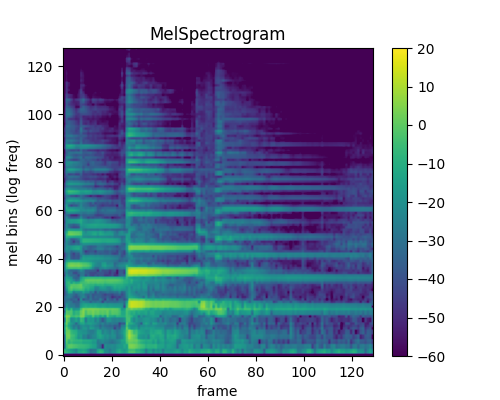

name =  LowpassFilter , ind = 12240


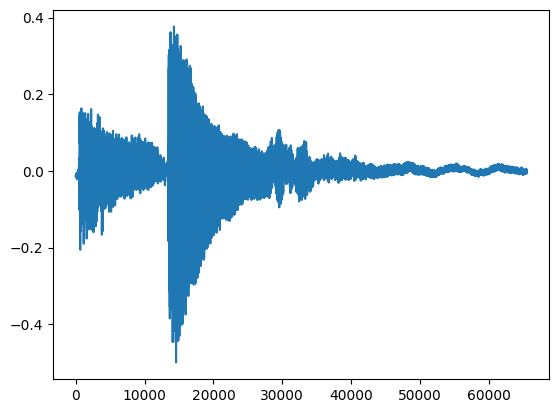

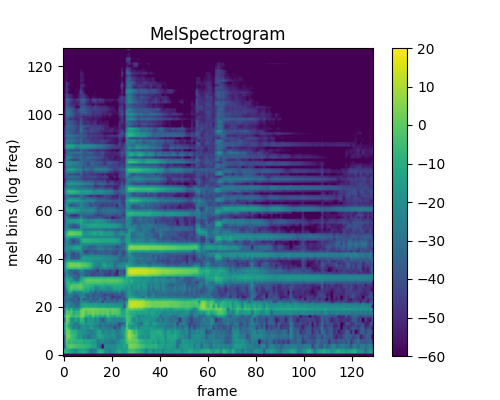

In [ ]:
for i, name in enumerate(effect_names):
    ind = (i+31)*len(dataset)
    print("name = ",name,", ind =",ind)
    nb_play(audio_full[ind])

# Visualize Embeddings

In [ ]:
use_wandb = False
if use_wandb: wandb.init(project='fx-viz')

In [ ]:
try: kturns
except NameError: kturns = reps_full.shape[0]//len(effects_list)//len(dataset)
print("kturns = ",kturns)

# downsampling and color scheme
ds_preproj, ds_preplot, color_scheme = 1,1, len(effects_list)*kturns
ds_preproj, ds_preplot, color_scheme

kturns =  79


(1, 1, 316)

In [ ]:
tokens_spectrogram_image(reps_full[0].unsqueeze(0), symmetric=True)

## Means
along time axis

In [ ]:
reps_full.shape

In [ ]:
#time_means = torch.mean(reps_full, dim=(2)).unsqueeze(-1) # average all times
#time_means = rearrange(reps_full, 'b d n -> b (d n)').unsqueeze(-1) # not really time means all times as dimensions

time_means = None
time_bins = 1   # time-averaging sections. 1=average over all time,  3 = early, middle, & late, etc...
for ti in range(time_bins):
    interval = reps_full.shape[-1]//time_bins
    start, end = ti*interval, min( (ti+1)*interval, reps_full.shape[-1])
    time_bin = torch.mean(reps_full[:,:,start:end], dim=(2)).unsqueeze(-1) # early, middle, late averages
    time_means = time_bin if time_means is None else torch.cat([time_means, time_bin] ,dim=(2))
time_means.shape

In [ ]:
#do the projection
proj_type = 'averages' # 'high-dim' # high dimensional points, each spectrogram as single point in d*n-dimensional space
proj_dims = 3
pca_time_means = project_down(time_means, method='pca', proj_dims=proj_dims).squeeze()
print(f"pca_time_means (i.e. proj_data) .shape = ",pca_time_means.shape)

In [ ]:
means_df = main_df.copy()
proj_data = pca_time_means
means_df['pc1'] = proj_data[:,0]
means_df['pc2'] = proj_data[:,1]
means_df['pc3'] = proj_data[:,2] if proj_dims>=3 else 0*proj_data[:,0]
means_df['sizes'] = [2]*len(proj_data)
means_df['instrument'] = means_df['filename'].replace('.*Recital.*','Piano', regex=True)
means_df['instrument'] = means_df['instrument'].replace('.*mic.*','Guitar', regex=True)

In [ ]:
# make a pandas df to plot via plotly express
'''
def make_df(proj_data, effects_list, proj_dims=3, every_n=128):
    "# Creating the pandas DataFrame"
    print("make_df: proj_data.shape = ",proj_data.shape)
    proj_data = rearrange(proj_data, 'b n d -> (b n) d') # this is just for plotting, we need a long list of 3-points
    print("make_df: after rearrange, proj_data.shape =",proj_data.shape)
    reshape_data = torch.reshape(proj_data, (len(effects_list), -1, proj_dims)).cpu().numpy()
    print("reshape_data.shape =",reshape_data.shape)
    proj_data = proj_data.cpu().numpy()

    pc1_col = proj_data[::every_n,0]
    pc2_col = proj_data[::every_n,1]
    pc3_col = proj_data[::every_n,2] if proj_dims>=3 else 0*proj_data[::every_n,0]
    sizes = [2]*len(proj_data)
    effect_labels = effect_names if kturns==1 else [x+'-'+y for x in effect_names for y in ['1Low','2Mid','3Hi']]
    effects_col = np.repeat(np.array(effect_labels),reshape_data.shape[1]//kturns)[::every_n]
    print("pc1_col.shape = ",pc1_col.shape)
    df = pd.DataFrame({'pc1':pc1_col,'pc2':pc2_col,'pc3':pc3_col,'effect':effects_col, 'sizes':sizes})
    df = df[df.effect != 'Clean-3Hi']
    df = df[df.effect != 'Clean-2Mid']
    df['effect'] = df['effect'].replace('Clean-1Low','Clean')
    df['row'] = df.reset_index().index
    df = df.reset_index(drop=True)
    df['sample'] = df['row'] % len(dataset)
    df['filename'] = df.apply(lambda x: os.path.basename(filenames[x['sample']]), axis=1)
    df['instrument'] = df['filename'].replace('.*Recital.*','Piano', regex=True)
    df['instrument'] = df['instrument'].replace('.*mic.*','Guitar', regex=True)
    #data_groups = df['effect'].unique().tolist()
    #print("data_groups = \n",data_groups)
    #df['color'] = df['effect'].apply(map_options, args=(data_groups,))
    return df 

#means_df = make_df(pca_time_means, effects_list, proj_dims=proj_dims, every_n=1)
#len(means_df)# , 16*len(dataset), 18*len(dataset)
'''

In [ ]:
# look at where first audio file gets mapped to:
means_df.iloc[0::len(dataset)]

In [ ]:
'''
px_color_options =[
    'rgba(100, 100, 100, 1.0)', # clean
    'rgba(135, 0, 0, 1.0)',   # distortion low
    'rgba(135, 0, 125, 1.0)', # d mid
    'rgba(135, 0, 250, 1.0)', # d high
    'rgba(0, 0, 135, 1.0)',    # reverb low
    'rgba(125, 0, 135, 1.0)',  # r mid
    'rgba(250, 0, 135, 1.0)',  # r high
    'rgba(135, 0, 250, 1.0)', # comp l
    'rgba(135, 125, 250, 1.0)', # comp m
    'rgba(135, 250, 250, 1.0)', # comp h
    'rgba(10, 80, 100, 1.0)', # 'HighpassFilter-1Low'
    'rgba(50, 140, 160, 1.0)', # hpf mid
    'rgba(100, 200, 255, 1.0)',  # hpf h
    'rgba(0, 100, 0, 1.0)',  # lpf l
    'rgba(0, 170, 0, 1.0)',  # lpf m
    'rgba(0, 250, 0, 1.0)',  # lpf h
]
print(len(px_color_options))
data_groups = means_df['effect'].unique().tolist()
colors_dict = {x:y for x,y in zip(data_groups,px_color_options)}
colors_dict
'''

In [ ]:
fig = px.scatter_3d(means_df[::1000], x='pc1', y='pc2', z='pc3', color='effect',  #color_discrete_map=colors_dict, 
                    labels='effect', opacity=1, size='sizes', 
                    hover_data=['sample','instrument'], size_max=10)
fig.update_traces(marker=dict(size=2.5, opacity=1,  line=dict(width=0, color='DarkSlateGrey')), selector=dict(mode='markers'))
if use_wandb: wandb.log({"pca_time_means":fig})
fig.show()

In [ ]:
%%time
#umap_time_means = project_down(time_means, method='umap')
proj_dims = 3
n_neighbors=50 # umap parameter for number of neighbors
min_dist=0.2   # umap param for minimum distance
if proj_type == 'high-dim':
    A = rearrange(time_means, 'b d n -> b (d n)').cpu().numpy() # treat each spectrogram as single point in d*n-dimensional space
else:
    A = rearrange(time_means, 'b d n -> (b n) d').cpu().numpy() # group time averages as d-dim individual vectors
print("Before UMAP, A.shape =",A.shape)
mapper = umap.UMAP(n_components=proj_dims, n_neighbors=n_neighbors, min_dist=min_dist,
                            metric='correlation').fit(A)

In [ ]:
%%time
proj_data = mapper.transform(A)

In [ ]:
umap_time_means =  torch.reshape(torch.from_numpy(proj_data), (time_means.size()[0], -1, proj_dims))
umap_means_df = make_df(umap_time_means, effects_list, proj_dims=3, every_n=1)
fig = px.scatter_3d(umap_means_df, x='pc1', y='pc2', z='pc3', labels='effect', color='effect',
                    #color_discrete_map=colors_dict,  
                    size='sample', hover_data=['sample','instrument'], opacity=1, size_max=10)
fig.update_traces(marker=dict(size=3,  opacity=1, line=dict(width=0, color='DarkSlateGrey')), selector=dict(mode='markers'))
if use_wandb: wandb.log({"umap_time_means":fig})
fig.show()

In [ ]:
if kturns == 1:
    A2 = A
else:
    A2 = np.delete(A,np.s_[len(dataset):kturns*len(dataset)],0) # delete the extra 'cleans'
A.shape, A2.shape

In [ ]:
%%time
mapper2d = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist,
                            metric='correlation').fit(A2)

In [ ]:
data2d = mapper2d.transform(A2)
data2d.shape

In [ ]:
means_df

In [ ]:
umap.plot.output_notebook()
umap.plot.points(mapper2d, labels=means_df['effect'])

In [ ]:
#interactive plot
hover_data = pd.DataFrame({#'index':means_df['row'], 
                           'label':means_df['effect'],
                           'sample':means_df['sample'], 'instrument':means_df['instrument']
                          })
p = umap.plot.interactive(mapper2d, labels=means_df['effect'].tolist(), hover_data=hover_data, point_size=3)
umap.plot.show(p)

In [ ]:
data_groups = means_df['effect'].unique().tolist()
data_groups, len(data_groups)

In [ ]:
data2d.shape

In [ ]:
import matplotlib.cm as cm
grouplen = len(dataset)
t = np.arange(grouplen)
cmaps = ['Greys','Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
executable_cmaps = [cm.Greys, cm.Purples, cm.Blues, cm.Greens, cm.Oranges, cm.Reds]
cmaps = [x+'_r' for x in cmaps]


In [ ]:
chosen_groups = effect_names
#assert len(chosen_groups)==6

fig, ax = plt.subplots(3, 2, figsize=(10, 6), layout='constrained')
for ci, chosen_group in enumerate(chosen_groups):
    valid_groups = [x  for x in data_groups if chosen_group in x]
    print("chosen_group = ",chosen_group, 'valid_groups =',valid_groups)
    axrow, axcol = ci//2, ci%2
    colors = executable_cmaps[ci](np.linspace(0.3, 1, len(valid_groups))) 
    print(colors.__class__.__name__)
    for i, (g, c) in enumerate(zip(valid_groups, colors)): 
        gi = data_groups.index(g)
        start, end = gi*len(dataset), (gi+1)*len(dataset)
        print(i,g,start,end)
        ax[axrow, axcol].scatter(data2d[start:end,0],data2d[start:end,1], s=6, label=g, alpha=0.5, color=c)
        ax[axrow, axcol].legend(fancybox=True, framealpha=0.3)
    
plt.setp(ax, xlim=[np.min(data2d[:,0]),np.max(data2d[:,0])] , ylim=[np.min(data2d[:,1]),np.max(data2d[:,1])])
plt.show()

In [ ]:
#start,end = ei*grouplen, min((ei+1)*grouplen, data2d.shape[0])
#plt.scatter(data2d[start:end,0],data2d[start:end,1],label=name, c=t, cmap=cmaps[ei], s=5)
#plt.legend()
#plt.show()

In [ ]:
umap.plot.connectivity(mapper2d, show_points=True)

In [ ]:
#umap.plot.connectivity(mapper2d, edge_bundling='hammer') #slowwww

In [ ]:
umap.plot.diagnostic(mapper2d, diagnostic_type='pca')

In [ ]:
umap.plot.diagnostic(mapper2d, diagnostic_type='vq')

In [ ]:
local_dims = umap.plot.diagnostic(mapper2d, diagnostic_type='local_dim')

In [ ]:
umap.plot.diagnostic(mapper2d, diagnostic_type='neighborhood')

In [ ]:
assert False


---

## Stop there

## Full Dataset: PCA & UMAP 

In [ ]:
pca_data = project_down(reps_full, method='pca')
effects_df = make_df(pca_data, effects_list, proj_dims=3)
fig = px.scatter_3d(effects_df, x='pc1', y='pc2', z='pc3', color='effect', opacity=1, size='sizes', size_max=10)
wandb.log({"pca_plotly":fig})
fig.show()

In [ ]:
%pip install umap-learn[plot]

In [ ]:
import umap
import umap.plot
import umap.utils as utils
import umap.aligned_umap

WARNING: This next one takes a long time to execute:

In [ ]:
%%time
umap_data = project_down(reps_full, method='umap', ds_preproj=ds_preproj) # ds_preproj>1 downsamples data to save time
umap_data.shape

In [ ]:
umap_df = make_df(umap_data, effects_list, proj_dims=3)
fig = px.scatter_3d(umap_df, x='pc1', y='pc2', z='pc3', color='effect', opacity=1, size='sizes', size_max=10)
wandb.log({"umap_plotly":fig})
fig.show()

In [ ]:
wandb.finish()

# Aligned UMAP (for time evolution)
instead of embedding only means or all time steps at once, we'll show a progression over several time steps

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
ordered_digits = digits.data[np.argsort(digits.data.sum(axis=1))]
print("ordered_digits.shape = ",ordered_digits.shape)
ordered_target = digits.target[np.argsort(digits.data.sum(axis=1))]
plt.matshow(ordered_digits[-1].reshape((8,8)))

t_overlap_start, t_final = 150, 400
slices = [ordered_digits[t_overlap_start * i:min(ordered_digits.shape[0], t_overlap_start * i + t_final)] for i in range(10)]
len(slices)

In [ ]:
slices = []
for i in range(10):
    start, end = t_overlap_start * i, min(ordered_digits.shape[0], i*t_overlap_start + t_final)
    print(f"i={i},  this start={start}, this end={end}")
    slice = ordered_digits[start:end]

In [ ]:
#relation_dict = {i+150:i for i in range(400-150)}
relation_dict = {i+t_overlap_start:i for i in range(t_final-t_overlap_start)}
relation_dict

In [ ]:
relation_dicts = [relation_dict.copy() for i in range(len(slices) - 1)]

In [ ]:
relation_dicts

In [ ]:
len(slices)

In [ ]:
%%time
aligned_mapper = umap.AlignedUMAP().fit(slices, relations=relation_dicts)

In [ ]:
def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(10, 20))
ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    current_target = ordered_target[150 * i:min(ordered_target.shape[0], 150 * i + 400)]
    ax.scatter(*aligned_mapper.embeddings_[i].T, s=2, c=current_target, cmap="Spectral")
    ax.axis(ax_bound)
    ax.set(xticks=[], yticks=[])
plt.tight_layout()

In [ ]:
%%time
updating_mapper = umap.AlignedUMAP().fit(slices[:2], relations=relation_dicts[:1])

In [ ]:
for i in range(2,len(slices)):
    %time updating_mapper.update(slices[i], relations={v:k for k,v in relation_dicts[i-1].items()})

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(10, 20))
ax_bound = axis_bounds(np.vstack(updating_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    current_target = ordered_target[150 * i:min(ordered_target.shape[0], 150 * i + 400)]
    ax.scatter(*updating_mapper.embeddings_[i].T, s=2, c=current_target, cmap="Spectral")
    ax.axis(ax_bound)
    ax.set(xticks=[], yticks=[])
plt.tight_layout()

### changing gears. all at once but time ev shows varying umap params

In [ ]:
constant_dict = {i:i for i in range(digits.data.shape[0])}
constant_relations = [constant_dict for i in range(9)]

In [ ]:
%%time
neighbors_mapper = umap.AlignedUMAP(
    n_neighbors=[3,4,5,7,11,16,22,29,37,45,54],
    min_dist=[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45],
    alignment_window_size=2,
    alignment_regularisation=1e-3,
).fit(
    [digits.data for i in range(10)], relations=constant_relations
)

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(10, 20))
ax_bound = axis_bounds(np.vstack(neighbors_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    ax.scatter(*neighbors_mapper.embeddings_[i].T, s=2, c=digits.target, cmap="Spectral")
    ax.axis(ax_bound)
    ax.set(xticks=[], yticks=[])
plt.tight_layout()

## worldlines plot

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

In [ ]:
n_embeddings = len(neighbors_mapper.embeddings_)
es = neighbors_mapper.embeddings_
embedding_df = pd.DataFrame(np.vstack(es), columns=('x', 'y'))
embedding_df['z'] = np.repeat(np.linspace(0, 1.0, n_embeddings), es[0].shape[0])
embedding_df['id'] = np.tile(np.arange(es[0].shape[0]), n_embeddings)
embedding_df['digit'] = np.tile(digits.target, n_embeddings)

In [ ]:
import scipy.interpolate
fx = scipy.interpolate.interp1d(
    embedding_df.z[embedding_df.id == 0], embedding_df.x.values.reshape(n_embeddings, digits.data.shape[0]).T, kind="cubic"
)
fy = scipy.interpolate.interp1d(
    embedding_df.z[embedding_df.id == 0], embedding_df.y.values.reshape(n_embeddings, digits.data.shape[0]).T, kind="cubic"
)
z = np.linspace(0, 1.0, 100)

In [ ]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [ ]:
palette = px.colors.diverging.Spectral
interpolated_traces = [fx(z), fy(z)]
traces = [
    go.Scatter3d(
        x=interpolated_traces[0][i],
        y=interpolated_traces[1][i],
        z=z*3.0,
        mode="lines",
        line=dict(
            color=palette[digits.target[i]],
            width=3.0
        ),
        opacity=1.0,
    )
    for i in range(digits.data.shape[0])
]
fig = go.Figure(data=traces)
fig.update_layout(
    width=800,
    height=700,
    autosize=False,
    showlegend=False,
)
fig.show()

In [ ]:
reps_alum = rearrange(reps_full, 'b d n -> n (b d)') # reps aligned umap
reps_alum.shape

In [ ]:
reps_full.shape

In [ ]:
from IPython.display import display, Image, HTML
from matplotlib import animation

In [ ]:
%matplotlib notebook

In [ ]:
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)

scat = ax.scatter([], [], s=2)
scat.set_array(digits.target)
scat.set_cmap('Spectral')
text = ax.text(ax_bound[0] + 0.5, ax_bound[2] + 0.5, '')
ax.axis(ax_bound)
ax.set(xticks=[], yticks=[])
plt.tight_layout()

offsets = np.array(interpolated_traces).T
num_frames = offsets.shape[0]

def animate(i):
    scat.set_offsets(offsets[i])
    text.set_text(f'Frame {i}')
    return scat

anim = animation.FuncAnimation(
    fig,
    init_func=None,
    func=animate,
    frames=num_frames,
    interval=40)

In [ ]:
2*8

In [ ]:
512*12/60/50

In [ ]:
512/32

In [ ]:
plt.imshow(digits.data[2].reshape(8,8))

In [ ]:
digits.data.shape

# Now trying my own Aligned UMAP

put time first:

In [ ]:
reps_full.shape

In [ ]:
reps_reshaped = rearrange(reps_full, 'b d n -> n b d')
reps_reshaped.shape

Create overlapping subdatasets

[lmciness' reply on March 20](https://github.com/lmcinnes/umap/issues/984#issuecomment-1476305655): 
> "given 512 time steps, we
could create a sequence of datasets where the  first dataset has data from
timesteps [0,1,2,3,4], the second dataset from timesteps [2,3,4,5,6], the
third dataset from timesteps [4,5,6,7,8], and so on."

In [ ]:
def window_it_fast(arr, win_size=None, overlap=None): 
    "but doesn't work"
    nt = len(arr)
    if win_size is None: win_size = nt//8
    if overlap is None: overlap = win_size//2
    windows = (
        # expand_dims are used to convert a 1D array to 2D array.
        np.expand_dims(np.arange(win_size), 0) +
        np.expand_dims(np.arange(len(arr)-win_size + 1), 0).T
    )  
    stride = win_size-overlap
    return arr[windows[::stride],:]


def window_it(arr, win_size=None, overlap=None, debug=False): 
    ""
    if debug: print(f"window_it: initial shape = {arr.shape}. Windowing on the {arr.shape[0]}." )
    rows = []
    nt = len(arr)
    if win_size is None: win_size = nt//8 
    if overlap is None: overlap = win_size//2
    stride = win_size - overlap
    if debug: print(f"win_size = {win_size}, overlap = {overlap}, stride = {stride}")
    # slow but sure way
    for start in range(0, nt-win_size+1, stride):
        chunk = arr[start:min(start+win_size, nt)]
        if debug: print(f"start = {start}")#", chunk = \n", chunk)
        rows.append(chunk)
    return np.array(rows)
    

test = np.linspace((1,2,3,4),(100,101,102,103),16)
print("test: shape =",test.shape,'\n', test,'\n')

wt = window_it(test, win_size=4, overlap=2, debug=True)
print("windowed:  shape =",wt.shape,'\n', wt,'\n')

In [ ]:
win_size = 5# reps_reshaped.shape[0]//16
overlap = 3# win_size//8
print("win_size, overlap =",win_size, overlap)
reps_windowed = window_it(reps_reshaped.cpu().numpy(), win_size=win_size, overlap=overlap, debug=True)
reps_windowed.shape

In [ ]:
slices = reps_windowed
relation_dict = {i+2:i for i in range(len(slices[0]))}
relation_dicts = [relation_dict.copy() for i in range(len(slices) - 1)]
len(relation_dict)

In [ ]:
ds_fac = 64
slices = reps_reshaped[::ds_fac].cpu().numpy()
slices.shape

In [ ]:
len(slices[0])

In [ ]:
relation_dict = {i:i for i in range(len(slices[0]))}
relation_dicts = [relation_dict.copy() for i in range(len(slices) - 1)]
len(relation_dict)

In [ ]:
%%time
aligned_mapper = umap.AlignedUMAP().fit(slices, relations=relation_dicts, 
                            n_neighbors=100, min_dist=0.2,
                                alignment_regularisation=0.1, alignment_window_size=2,)

In [ ]:
def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(10, 20))
ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    print("i = ",i)
    if i >= slices.shape[0]: 
        print("breaking")
        break
    #current_target = ordered_target[150 * i:min(ordered_target.shape[0], 150 * i + 400)]
    current_target = np.arange(slices.shape[1])//len(dataset)
    ax.scatter(*aligned_mapper.embeddings_[i].T, s=2,  c=current_target, cmap="Spectral")
    ax.axis(ax_bound)
    ax.set(xticks=[], yticks=[])
plt.tight_layout()

# bunch of individual time steps

In [ ]:
proj_dims = 3
n_neighbors=100 # umap parameter for number of neighbors
min_dist=0.2    # umap param for minimum distance
for i in range(0, reps_full.shape[-1], 64):
    print("i = ",i)
    time_means = reps_full[:,:,i].unsqueeze(-1) # torch.mean(reps_full, dim=(2)).unsqueeze(-1) # average over time
    A = rearrange(time_means, 'b d n -> (b n) d').cpu().numpy()
    #mapper = umap.UMAP(n_components=proj_dims, n_neighbors=n_neighbors, min_dist=min_dist,
    #                            metric='correlation').fit(A)
    mapper2d = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist,
                            metric='correlation').fit(A)
    #data2d = mapper2d.transform(A)
    umap.plot.points(mapper2d, labels=means_df['effect'])
    plt.show()

In [ ]:
reps_full.shape, A.shape

In [ ]:
A3 = rearrange(reps_full, 'b d n -> b (n d)').cpu().numpy()
A3.shape

In [ ]:
%%time
proj_dims = 3
n_neighbors=100 # umap parameter for number of neighbors
min_dist=0.2    # umap param for minimum distance
A3 = rearrange(reps_full, 'b d n -> b (n d)').cpu().numpy()
mapper2d = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist,
                        metric='correlation').fit(A3)
umap.plot.points(mapper2d, labels=means_df['effect'])
plt.show()

# FX2FX 
Can we map from one effect to another? Using the average over all audio files first

In [ ]:
reps_full = reps_full.to(device) 
reps_full.shape, reps_full.device

In [ ]:
src_name, dst_name =  "LowpassFilter", "HighpassFilter"
[src_ind, dst_ind] = [effect_names.index(x) for x in [src_name, dst_name]]
src_ind, dst_ind

Get average vector displacement using embeddings and all time steps

In [ ]:
total_dims = reps_full.shape[1] * reps_full.shape[-1]
total_dims

### Compute the difference

In [ ]:
class FX2FX:
    def __init__(self):
        self.diff = None
        
    def compute_diff(self, src_name, dst_name):
        [src_ind, dst_ind] = [effect_names.index(x) for x in [src_name, dst_name]]
        n = len(dataset) # TODO: note that globals len_dataset and reps_full are needed
        
        # elementwise subtraction between two effect variations, across all samples across all dimensions & time steps
        diff = reps_full[dst_ind*n:(dst_ind+1)*n] - reps_full[src_ind*n:(src_ind+1)*n]
        print("first diff.shape =",diff.shape)
        avg_diff = torch.mean(diff,dim=0) # average that across samples
        
        #avg_diff = diff[0] # cheeeating!! 
        self.diff = avg_diff
        print("compute_diff: diff.shape =",self.diff.shape)
        return self.diff

    def apply_diff(self, src_rep):
        return src_rep + self.diff

fx2fx = FX2FX()
diff = fx2fx.compute_diff(src_name, dst_name)

tokens_spectrogram_image(diff.unsqueeze(0))

#### Pick some audio in

In [ ]:
src_audio = torch.from_numpy(audio_full[src_ind*n])
src_audio.shape

In [ ]:
src_rep = given_model.encode(src_audio.unsqueeze(0).to(device))
print(src_rep.shape)

In [ ]:
tokens_spectrogram_image(src_rep)

"Control": decode the source rep

In [ ]:
control_audio = given_model.decode(src_rep)

In [ ]:
nb_play(control_audio.cpu().numpy())

### Apply the transformation
Now make the transformation to get "pred" audio

In [ ]:
pred_dst_rep = fx2fx.apply_diff(src_rep)
pred_dst_rep.shape

In [ ]:
tokens_spectrogram_image(pred_dst_rep)

#### Now decode

In [ ]:
pred_audio = given_model.decode(pred_dst_rep)
nb_play(pred_audio.cpu().numpy())

Compare against the effect applied as expected

In [ ]:
true_audio = torch.from_numpy(audio_full[dst_ind*n])
true_rep = given_model.encode(true_audio.unsqueeze(0).to(device))
tokens_spectrogram_image(true_rep)

In [ ]:
true_control_audio = given_model.decode(true_rep)
nb_play(true_control_audio.cpu().numpy())

Instead of using the average diff, let's see what the exact diff is between src & dst:

In [ ]:
exact_diff = true_rep - src_rep
tokens_spectrogram_image(exact_diff)

In [ ]:
exact_diff_audio = given_model.decode(exact_diff)
nb_play(exact_diff_audio.cpu().numpy())

In [ ]:
cheat_rep = src_rep + exact_diff
cheat_audio = given_model.decode(cheat_rep)
nb_play(cheat_audio.cpu().numpy())

In [ ]:
#check_diff = true_rep - cheat_rep # should be zero, right?
#tokens_spectrogram_image(check_diff)

In [ ]:
#check_diff_audio = given_model.decode(check_diff)
#nb_play(check_diff_audio.cpu().numpy())

In [ ]:
error_rep = true_rep - pred_dst_rep
tokens_spectrogram_image(error_rep)

In [ ]:
error_audio = given_model.decode(error_rep)
nb_play(error_audio.cpu().numpy())

---

what if we just ran effect 2 on effect 1's audio? 

In [ ]:
board = Pedalboard([LowpassFilter(cutoff_frequency_hz=250)])

In [ ]:
other_comp = board(src_audio.cpu().numpy(), 48000)
other_comp.shape

In [ ]:
nb_play(other_comp)

# PCA all dims * all times

In [ ]:
proj_dims = 2
A = rearrange(reps_full, 'b d n -> b (d n)') # put all the vectors into the same d-dim space
print("A.shape =",A.shape)
(U, S, V) = torch.pca_lowrank(A, q=1440)
proj_data = torch.matmul(A, V[:, :proj_dims])  # this is the actual PCA projection step
proj_data.shape

In [ ]:
U.shape, S.shape, V.shape

In [ ]:
proj_data = proj_data.cpu().numpy()
plt.scatter(proj_data[:,0], proj_data[:,1])

In [ ]:
plt.plot(S.cpu().numpy())

In [ ]:
A.shape, A.device

In [ ]:
guh = A.T @ A
guh.shape

In [ ]:
cov = torch.cov(A.T.to(device))
cov.shape

In [ ]:
L, V = torch.linalg.eig(cov)
L.shape

In [ ]:
torch.save(L, 'L_torch')

In [ ]:
L = L.sort()

# Varying Effect

In [ ]:
proj_type = 'averages' # 'high-dim' # high dimensional points, each spectrogram as single point in d*n-dimensional space

i = 0
effect_name = effect_names[i]
kinfo = knob_names[effect_name]  # knob info
#kturns = 10 #if name != 'Clean' else 1  # number of knob turns
kname, kdefault, kmin, kmax = kinfo['knob_name'], kinfo['default'], kinfo['min'], kinfo['max']
kvals = np.linspace(kmin, kmax, kturns)   


def make_df(proj_data, effects_list, proj_dims=3, every_n=1):
    "# Creating the pandas DataFrame"
    print("make_df: proj_data.shape = ",proj_data.shape)
    proj_data = rearrange(proj_data, 'b n d -> (b n) d') # this is just for plotting, we need a long list of 3-points
    print("make_df: after rearrange, proj_data.shape =",proj_data.shape)
    reshape_data = torch.reshape(proj_data, (len(effects_list), -1, proj_dims)).cpu().numpy()
    print("reshape_data.shape =",reshape_data.shape)
    proj_data = proj_data.cpu().numpy()

    pc1_col = proj_data[::every_n,0]
    pc2_col = proj_data[::every_n,1]
    pc3_col = proj_data[::every_n,2] if proj_dims>=3 else 0*proj_data[::every_n,0]
    sizes = [2]*len(proj_data)
    
    name = effect_name
    kinfo = knob_names[name]  # knob info
    #kturns = 10 #if name != 'Clean' else 1  # number of knob turns
    kname, kdefault, kmin, kmax = kinfo['knob_name'], kinfo['default'], kinfo['min'], kinfo['max']
    kvals = np.linspace(kmin, kmax, kturns)   

    effect_labels = effect_names if kturns==1 else [f"{x}-{y:3.1f}" for x in effect_names for y in kvals]
    print("effect_labels = ",effect_labels)
    effects_col = np.repeat(np.array(effect_labels),reshape_data.shape[1]//kturns)[::every_n]
    print("pc1_col.shape = ",pc1_col.shape)
    df = pd.DataFrame({'pc1':pc1_col,'pc2':pc2_col,'pc3':pc3_col,'effect':effects_col, 'sizes':sizes})
    df = df[df.effect != 'Clean-3Hi']
    df = df[df.effect != 'Clean-2Mid']
    df['effect'] = df['effect'].replace('Clean-1Low','Clean')
    df['row'] = df.reset_index().index
    print(len(kvals), df['row']//len(dataset))
    df[kname] =  kvals[df['row']//len(dataset)]
    df = df.reset_index(drop=True)
    df['sample'] = df['row'] % len(dataset)
    df['filename'] = df.apply(lambda x: os.path.basename(filenames[x['sample']]), axis=1)
    df['instrument'] = df['filename'].replace('.*Recital.*','Piano', regex=True)
    df['instrument'] = df['instrument'].replace('.*mic.*','Guitar', regex=True)
    #data_groups = df['effect'].unique().tolist()
    #print("data_groups = \n",data_groups)
    #df['color'] = df['effect'].apply(map_options, args=(data_groups,))
    return df 

means_df = make_df(pca_time_means, effects_list, proj_dims=proj_dims, every_n=1)
len(means_df)# , 16*len(dataset), 18*len(dataset)

In [ ]:
cmaps = ['gray','inferno','viridis','plotly3','ice']
npaths = 36 # must go into len(dataset) evenly
assert len(dataset) % npaths == 0
ds_fac = len(dataset)//npaths
scale = cmaps[['Clean','Distortion','Reverb','LowpassFilter','HighpassFilter'].index(effect_name)]
fig = px.scatter_3d(means_df[::ds_fac], x='pc1', y='pc2', z='pc3', color=kname, 
                    labels='effect', opacity=1, size='sample',  color_continuous_scale=scale,
                    hover_data=['sample','instrument'], size_max=10)
fig.update_traces(marker=dict(size=5, opacity=1,  line=dict(width=0, color='DarkSlateGrey')), selector=dict(mode='markers'))

if use_wandb: wandb.log({"pca_time_means":fig})
fig.show()

## Single point, effect paths

In [ ]:
use_wandb = False

In [ ]:
proj_data = pca_time_means.squeeze()
print("proj_data.shape =",proj_data.shape)
df = pd.DataFrame(proj_data, columns=['pc1','pc2','pc3'])
assert len(df) == len(effects_list)*kturns*len(dataset)
df['kval'] = list(np.repeat(range(kturns),len(dataset)))*len(effects_list)
stride_ss = len(dataset) # stride for same sample

In [ ]:
effect_len = len(dataset)*kturns
cmaps = ['gray','inferno','viridis','plotly3_r','ice']

sample_num = 0 
for i in range(len(effects_list)):
    name = effect_names[i]
    scale = cmaps[['Clean','Distortion','Reverb','LowpassFilter','HighpassFilter'].index(name)]
    kinfo = knob_names[name]
    knob_name, kmin, kmax = kinfo['knob_name'], kinfo['min'], kinfo['max']
    
    kvals = np.logspace(np.log10(kmin), np.log10(kmax), kturns) if 'Filter' in name else np.linspace(kmin, kmax, kturns)
    df['kval'] = list(np.repeat(kvals,len(dataset)))*len(effects_list)

    df[knob_name] = df['kval']
    print(f"i = {i}: {effects_list[i]}, {scale}")
    start, end = sample_num+ i*effect_len, sample_num+ (i+1)*effect_len
    if i==0: 
        fig = px.scatter_3d(df[start:end:stride_ss], x='pc1', y='pc2', z='pc3', color=knob_name, color_continuous_scale=scale,  width=1000, height=600)
        fig.layout.coloraxis.colorbar.x = -0.25
        #fig.layout.coloraxis1 = fig.layout.coloraxis
    else:
        newfig = px.scatter_3d(df[start:end:stride_ss], x='pc1', y='pc2', z='pc3', color=knob_name, color_continuous_scale=scale)
        fig.add_traces(list(newfig.select_traces()))
        if i==1:
            fig.layout.coloraxis2 = newfig.layout.coloraxis   # override fig.layout
            fig.layout.coloraxis2.colorbar.x = 0.95
        elif i==2:
            fig.layout.coloraxis3 = newfig.layout.coloraxis   # override fig.layout
            fig.layout.coloraxis3.colorbar.x = -0.1
        elif i==3:
            fig.layout.coloraxis4 = newfig.layout.coloraxis   # override fig.layout
            fig.layout.coloraxis4.colorbar.x = 1.1

    fig['data'][i]['marker'] = {'color':np.array(df[start:end:stride_ss]['kval']),'coloraxis':f'coloraxis{i+1}'}
    print("len(fig['data']) =",len(fig['data']))   
#fig.update_traces(marker=dict(size=5, opacity=1,  line=dict(width=0, color='DarkSlateGrey')), selector=dict(mode='markers'))

if use_wandb: wandb.log({"one_point_multieffects":fig})
fig.show()

In [ ]:
i=1
start, end = i*effect_len, (i+1)*effect_len
print("start, end =",start, end)

fig = px.scatter_3d(df[start:end:stride_ss], x='pc1', y='pc2', z='pc3', color='kval', color_continuous_scale='inferno', )

# change reference params

fig.layout.coloraxis.colorbar.x = 1.5
fig.update_coloraxes(colorscale="viridis")
#fig.update_traces(contours_coloring="fill")

# add new traces with new params

i=2
start, end = i*effect_len, (i+1)*effect_len
print("start, end =",start, end)

fig2 = px.scatter_3d(df[start:end:stride_ss], x='pc1', y='pc2', z='pc3', color='kval', color_continuous_scale='ice')
fig.add_traces(list(fig2.select_traces()))
fig.show()

In [ ]:
# busy work
from time import sleep

while True:
    print("\rHey",end="",flush=True)
    sleep(5)

In [ ]:
print yo